In [1]:
from pyalgotrade import strategy
from pyalgotrade import technical
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns
import tushare as ts

In [2]:
# 自定义事件窗口类
class DiffEventWindow(technical.EventWindow):
    def __init__(self, period):
        assert(period > 0)
        super(DiffEventWindow, self).__init__(period)
        self.__value = None

    def onNewValue(self, dateTime, value):
        super(DiffEventWindow, self).onNewValue(dateTime, value)
        if self.windowFull():
            lastValue = self.getValues()[0]
            nowValue = self.getValues()[1]
            self.__value = (nowValue - lastValue) / lastValue

    def getValue(self):
        return self.__value

In [3]:
# 自定义指标
class Diff(technical.EventBasedFilter):
    def __init__(self, dataSeries, period, maxLen=None):
        super(Diff, self).__init__(dataSeries, DiffEventWindow(period), maxLen)

In [4]:
# 定义自己的策略
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, diffPeriod=2):
        super(MyStrategy, self).__init__(feed, 1000000)
        self.__instrument = instrument
        self.__position = None
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__diff = Diff(self.__prices, diffPeriod)
        self.__break = 0.05
        self.__withdown = -0.05

    def getDiff(self):
        return self.__diff

    def onEnterCanceled(self, position):
        self.__position = None

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at $%.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        account = self.getBroker().getCash()
        bar = bars[self.__instrument]
        if self.__position is None:
            one = bar.getPrice() * 500
            oneUnit = account // one
            if oneUnit > 0 :
                self.__position = self.enterLong(self.__instrument, oneUnit * 500, True)
        elif self.__diff[-1] < self.__withdown and not self.__position.exitActive():
            self.__position.exitMarket()

In [5]:
def runStrategy():
    # 下载数据
    jdf = ts.get_k_data("600519",start='2018-07-01',end='2020-07-01')

    # 新建Adj Close字段
    jdf["Adj Close"] =jdf.close

    # 将tushare下的数据的字段保存为pyalgotrade所要求的数据格式
    jdf.columns = ["Date", "Open", "Close", "High", "Low", "Volume", "code", "Adj Close"]

    # 将数据保存成本地csv文件
    jdf.to_csv("jdf.csv", index=False)

    feed = yahoofeed.Feed()
    feed.addBarsFromCSV("jdf", "jdf.csv")

    myStrategy = MyStrategy(feed, "jdf")

    returnsAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(returnsAnalyzer)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getInstrumentSubplot("jdf")
    plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())

    myStrategy.run()
    print("Final portfolio value: $%.2f" % myStrategy.getResult())
    plt.plot()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


2018-07-03 00:00:00 strategy [INFO] BUY at $709.76
2018-10-09 00:00:00 strategy [INFO] SELL at $686.90
2018-10-10 00:00:00 strategy [INFO] BUY at $697.26
2018-10-24 00:00:00 strategy [INFO] SELL at $628.11
2018-10-25 00:00:00 strategy [INFO] BUY at $620.00
2018-10-30 00:00:00 strategy [INFO] SELL at $510.00
2018-10-31 00:00:00 strategy [INFO] BUY at $527.00
2019-05-07 00:00:00 strategy [INFO] SELL at $893.28
2019-05-08 00:00:00 strategy [INFO] BUY at $860.00


Final portfolio value: $2298815.00


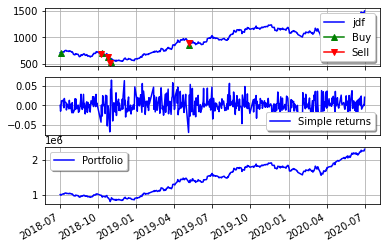

In [6]:
runStrategy()

可以看到，在2018.7.1-2020.7.1期间，从最初的本金100万，达到了最终的资产229万